In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("="*80)
print("SPECTRAL CLUSTERING FOR CUSTOMER SEGMENTATION")
print("="*80)

SPECTRAL CLUSTERING FOR CUSTOMER SEGMENTATION


In [5]:
print("\n[STEP 1] Loading and Preprocessing Data...")
# Load the customer dataset
customer_df = pd.read_csv('marketing_campaign.csv',
                          sep='\t',              
                          engine='python',      
                          encoding='utf-8',
                          quoting=3,             
                          on_bad_lines='skip')   

print(f"Dataset shape: {customer_df.shape}")
print(f"\nFirst few rows:")
customer_df.head()




[STEP 1] Loading and Preprocessing Data...
Dataset shape: (2240, 29)

First few rows:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [6]:
# Check for missing values
print("\nMissing values per column:")
print(customer_df.isnull().sum())

# Drop missing values
customer_df = customer_df.dropna()
print(f"\nAfter dropping missing values: {customer_df.shape}")


Missing values per column:
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

After dropping missing values: (2216, 29)


In [7]:
# Process date and time features
customer_df['Dt_Customer'] = pd.to_datetime(customer_df['Dt_Customer'], dayfirst=True)
customer_df['Age'] = 2025 - customer_df['Year_Birth']
customer_df['Customer_days'] = (pd.to_datetime('2025-11-15') - customer_df['Dt_Customer']).dt.days

# Encode categorical variables
education_order = ['Basic', 'Graduation', 'Master', '2n Cycle', 'PhD']
value_to_code = {value: i for i, value in enumerate(education_order)}
customer_df['education_encoded'] = customer_df['Education'].map(value_to_code)

mapping = lambda x: 0 if x in ['Together', 'Married'] else 1
customer_df['alone_encoded'] = customer_df['Marital_Status'].apply(mapping)

# Create aggregated features
customer_df['num_child'] = customer_df['Kidhome'] + customer_df['Teenhome']
customer_df['spend'] = (customer_df['MntFishProducts'] + customer_df['MntFruits'] + 
                        customer_df['MntGoldProds'] + customer_df['MntWines'] + 
                        customer_df['MntMeatProducts'] + customer_df['MntSweetProducts'])
customer_df['num_cmp_accepted'] = (customer_df['AcceptedCmp1'] + customer_df['AcceptedCmp2'] + 
                                   customer_df['AcceptedCmp3'] + customer_df['AcceptedCmp4'] + 
                                   customer_df['AcceptedCmp5'] + customer_df['Response'])

print("\n✓ Feature engineering completed")


✓ Feature engineering completed


In [8]:
# Drop unnecessary columns
customer_df_encoded = customer_df.drop(columns=[
    'Dt_Customer', 'Year_Birth', 'Z_CostContact', 'Z_Revenue', 'ID', 
    'Marital_Status', 'Education', 'AcceptedCmp1', 'AcceptedCmp2', 
    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 
    'NumWebVisitsMonth', 'Kidhome', 'Teenhome', 'MntFishProducts', 
    'MntFruits', 'MntGoldProds', 'MntWines', 'MntMeatProducts', 'MntSweetProducts'
])

print(f"\nFinal processed dataset shape: {customer_df_encoded.shape}")
print(f"Features used: {list(customer_df_encoded.columns)}")

# Display statistics
print("\nDataset Statistics:")
customer_df_encoded.describe().T


Final processed dataset shape: (2216, 14)
Features used: ['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Complain', 'Age', 'Customer_days', 'education_encoded', 'alone_encoded', 'num_child', 'spend', 'num_cmp_accepted']

Dataset Statistics:


,count,mean,std,min,25%,50%,75%,max
Income,2216.0,52247.251354,25173.076661,1730.0,35303.0,51381.5,68522.0,666666.0
Recency,2216.0,49.012635,28.948352,0.0,24.0,49.0,74.0,99.0
NumDealsPurchases,2216.0,2.323556,1.923716,0.0,1.0,2.0,3.0,15.0
NumWebPurchases,2216.0,4.085289,2.740951,0.0,2.0,4.0,6.0,27.0
NumCatalogPurchases,2216.0,2.671029,2.926734,0.0,0.0,2.0,4.0,28.0
NumStorePurchases,2216.0,5.800993,3.250785,0.0,3.0,5.0,8.0,13.0
Complain,2216.0,0.009477,0.096907,0.0,0.0,0.0,0.0,1.0
Age,2216.0,56.179603,11.985554,29.0,48.0,55.0,66.0,132.0
Customer_days,2216.0,4510.521209,202.434667,4157.0,4337.0,4512.5,4686.0,4856.0
education_encoded,2216.0,1.972022,1.248795,0.0,1.0,1.0,3.0,4.0


In [9]:
print("\n[STEP 2] Applying PCA Dimensionality Reduction...")

# Normalize the data (standardization)
mean = customer_df_encoded.mean()
std = customer_df_encoded.std()
customer_df_encoded_centered = (customer_df_encoded - mean) / std

print("✓ Data standardized")


[STEP 2] Applying PCA Dimensionality Reduction...
✓ Data standardized


In [10]:
# Apply PCA to keep at least 80% of variance
pca = PCA(n_components=8, random_state=42)
X_pca = pca.fit_transform(customer_df_encoded_centered)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"\nExplained variance by 8 PCs: {explained_variance:.4f} ({explained_variance*100:.2f}%)")
print(f"\nIndividual PC variance ratios:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%)")


Explained variance by 8 PCs: 0.8075 (80.75%)

Individual PC variance ratios:
  PC1: 0.2680 (26.80%)
  PC2: 0.1146 (11.46%)
  PC3: 0.0845 (8.45%)
  PC4: 0.0754 (7.54%)
  PC5: 0.0728 (7.28%)
  PC6: 0.0706 (7.06%)
  PC7: 0.0644 (6.44%)
  PC8: 0.0572 (5.72%)


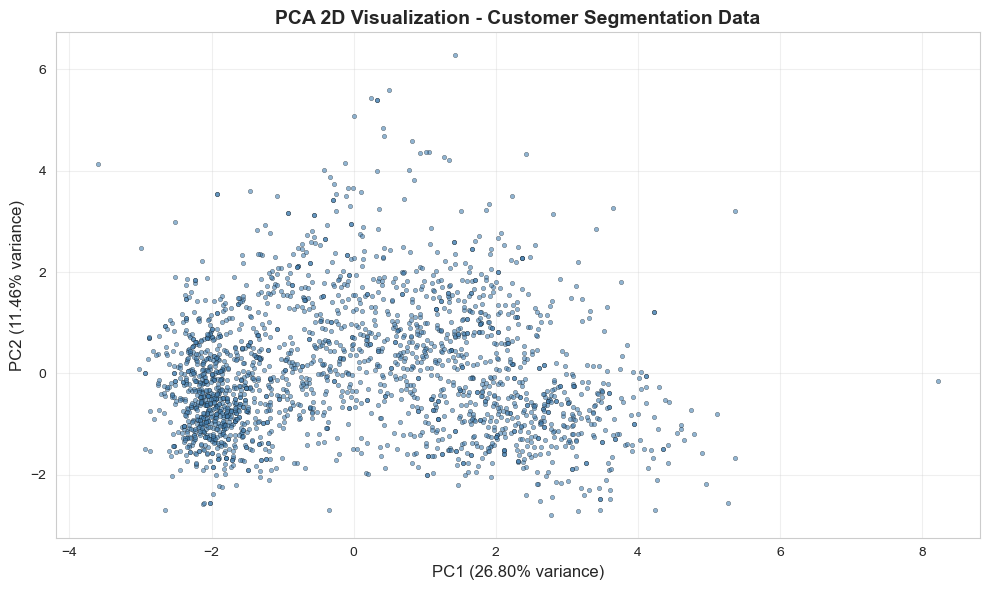

✓ PCA visualization complete


In [11]:
# Visualize PCA result
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.6, c='steelblue', edgecolors='k', linewidth=0.3)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=12)
plt.title('PCA 2D Visualization - Customer Segmentation Data', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ PCA visualization complete")

In [12]:
print("\n[STEP 3] Spectral Clustering - Hyperparameter Tuning...")
print("-" * 80)

# Define hyperparameter ranges for tuning
n_clusters_range = [2, 3, 4, 5, 6]
affinity_types = ['nearest_neighbors', 'rbf']
n_neighbors_range = [5, 10, 15, 20]
gamma_range = [0.1, 0.5, 1.0, 2.0]

results_list = []

print("\nTesting different hyperparameter combinations...")
print(f"{'n_clusters':<12} {'affinity':<20} {'param':<15} {'silhouette':<12} {'davies_bouldin':<15} {'calinski_harabasz':<20}")
print("-" * 95)


[STEP 3] Spectral Clustering - Hyperparameter Tuning...
--------------------------------------------------------------------------------

Testing different hyperparameter combinations...
n_clusters   affinity             param           silhouette   davies_bouldin  calinski_harabasz   
-----------------------------------------------------------------------------------------------


In [13]:
print("\n[STEP 3] Spectral Clustering - Hyperparameter Tuning...")
print("-" * 80)
n_clusters_range = [2, 3, 4, 5]          
n_neighbors_range = [5, 10, 20]        
gamma_range = [0.1, 0.3, 1.2]           

results_list = []

print("\nTesting different hyperparameter combinations...")
print(f"Total combinations to test: {len(n_clusters_range) * (len(n_neighbors_range) + len(gamma_range))}")
print(f"Estimated time: ~2-5 minutes\n")
print(f"{'n_clusters':<12} {'affinity':<20} {'param':<15} {'silhouette':<12} {'davies_bouldin':<15} {'calinski_harabasz':<20}")
print("-" * 95)

import time
start_time = time.time()

# Grid search for hyperparameter tuning
for n_clusters in n_clusters_range:
    print(f"\n--- Testing n_clusters={n_clusters} ---")
    
    # Test nearest_neighbors affinity
    for n_neighbors in n_neighbors_range:
        try:
            sc = SpectralClustering(
                n_clusters=n_clusters,
                affinity='nearest_neighbors',
                n_neighbors=n_neighbors,
                random_state=42,
                n_init=10
            )
            labels = sc.fit_predict(X_pca)
            
            # Calculate validation metrics
            sil_score = silhouette_score(X_pca, labels)
            db_score = davies_bouldin_score(X_pca, labels)
            ch_score = calinski_harabasz_score(X_pca, labels)
            
            results_list.append({
                'n_clusters': n_clusters,
                'affinity': 'nearest_neighbors',
                'n_neighbors': n_neighbors,
                'gamma': None,
                'silhouette': sil_score,
                'davies_bouldin': db_score,
                'calinski_harabasz': ch_score
            })
            
            print(f"{n_clusters:<12} {'nearest_neighbors':<20} {f'n_neighbors={n_neighbors}':<15} "
                  f"{sil_score:<12.4f} {db_score:<15.4f} {ch_score:<20.2f}")
            
        except Exception as e:
            print(f"Error with n_clusters={n_clusters}, n_neighbors={n_neighbors}: {str(e)}")
    
    # Test rbf affinity (with adjusted gamma values)
    for gamma in gamma_range:
        try:
            sc = SpectralClustering(
                n_clusters=n_clusters,
                affinity='rbf',
                gamma=gamma,
                random_state=42,
                n_init=10
            )
            labels = sc.fit_predict(X_pca)
            
            # Calculate validation metrics
            sil_score = silhouette_score(X_pca, labels)
            db_score = davies_bouldin_score(X_pca, labels)
            ch_score = calinski_harabasz_score(X_pca, labels)
            
            results_list.append({
                'n_clusters': n_clusters,
                'affinity': 'rbf',
                'n_neighbors': None,
                'gamma': gamma,
                'silhouette': sil_score,
                'davies_bouldin': db_score,
                'calinski_harabasz': ch_score
            })
            
            print(f"{n_clusters:<12} {'rbf':<20} {f'gamma={gamma}':<15} "
                  f"{sil_score:<12.4f} {db_score:<15.4f} {ch_score:<20.2f}")
            
        except Exception as e:
            print(f"Error with n_clusters={n_clusters}, gamma={gamma}: {str(e)}")

elapsed_time = time.time() - start_time
print(f"\n⏱️  Total time: {elapsed_time:.1f} seconds ({elapsed_time/60:.2f} minutes)")
print(f"✅ Tested {len(results_list)} configurations")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results_list)

# Find best parameters based on silhouette score
best_result = results_df.loc[results_df['silhouette'].idxmax()]

print("\n" + "="*80)
print("BEST HYPERPARAMETERS (Based on Silhouette Score):")
print("="*80)
print(f"Number of clusters: {int(best_result['n_clusters'])}")
print(f"Affinity: {best_result['affinity']}")
if best_result['affinity'] == 'nearest_neighbors':
    print(f"n_neighbors: {int(best_result['n_neighbors'])}")
else:
    print(f"gamma: {best_result['gamma']}")
print(f"\nValidation Metrics:")
print(f"  - Silhouette Score: {best_result['silhouette']:.4f}")
print(f"  - Davies-Bouldin Index: {best_result['davies_bouldin']:.4f} (lower is better)")
print(f"  - Calinski-Harabasz Index: {best_result['calinski_harabasz']:.2f} (higher is better)")


[STEP 3] Spectral Clustering - Hyperparameter Tuning...
--------------------------------------------------------------------------------

Testing different hyperparameter combinations...
Total combinations to test: 24
Estimated time: ~2-5 minutes

n_clusters   affinity             param           silhouette   davies_bouldin  calinski_harabasz   
-----------------------------------------------------------------------------------------------

--- Testing n_clusters=2 ---
2            nearest_neighbors    n_neighbors=5   0.1110       2.8880          211.83              
2            nearest_neighbors    n_neighbors=10  0.6173       0.6052          216.56              
2            nearest_neighbors    n_neighbors=20  0.6173       0.6052          216.56              
2            rbf                  gamma=0.1       0.6173       0.6052          216.56              
2            rbf                  gamma=0.3       0.6173       0.6052          216.56              
2            rbf         

In [14]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results_list)

# Find best parameters based on silhouette score (higher is better)
best_result = results_df.loc[results_df['silhouette'].idxmax()]

print("\n" + "="*80)
print("BEST HYPERPARAMETERS (Based on Silhouette Score):")
print("="*80)
print(f"Number of clusters: {int(best_result['n_clusters'])}")
print(f"Affinity: {best_result['affinity']}")
if best_result['affinity'] == 'nearest_neighbors':
    print(f"n_neighbors: {int(best_result['n_neighbors'])}")
else:
    print(f"gamma: {best_result['gamma']}")
print(f"\nValidation Metrics:")
print(f"  - Silhouette Score: {best_result['silhouette']:.4f}")
print(f"  - Davies-Bouldin Index: {best_result['davies_bouldin']:.4f} (lower is better)")
print(f"  - Calinski-Harabasz Index: {best_result['calinski_harabasz']:.2f} (higher is better)")


BEST HYPERPARAMETERS (Based on Silhouette Score):
Number of clusters: 2
Affinity: nearest_neighbors
n_neighbors: 10

Validation Metrics:
  - Silhouette Score: 0.6173
  - Davies-Bouldin Index: 0.6052 (lower is better)
  - Calinski-Harabasz Index: 216.56 (higher is better)


In [15]:
print("\n[STEP 4] Elbow Method Analysis...")

inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    sc = SpectralClustering(
        n_clusters=k,
        affinity='nearest_neighbors',
        n_neighbors=10,
        random_state=42,
        n_init=10
    )
    labels = sc.fit_predict(X_pca)
    
    # Calculate within-cluster sum of squares (inertia approximation)
    unique_labels = np.unique(labels)
    inertia = 0
    for label in unique_labels:
        cluster_points = X_pca[labels == label]
        center = cluster_points.mean(axis=0)
        inertia += np.sum((cluster_points - center) ** 2)
    inertias.append(inertia)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_pca, labels)
    silhouette_scores.append(sil_score)
    
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette={sil_score:.4f}")


[STEP 4] Elbow Method Analysis...
k=2: Inertia=22810.35, Silhouette=0.6173
k=3: Inertia=20622.74, Silhouette=0.1248
k=4: Inertia=16573.30, Silhouette=0.1559
k=5: Inertia=14281.29, Silhouette=0.1495
k=6: Inertia=12966.20, Silhouette=0.1563
k=7: Inertia=12441.66, Silhouette=0.1365
k=8: Inertia=12085.58, Silhouette=0.1311
k=9: Inertia=11463.84, Silhouette=0.1418
k=10: Inertia=11128.51, Silhouette=0.1300


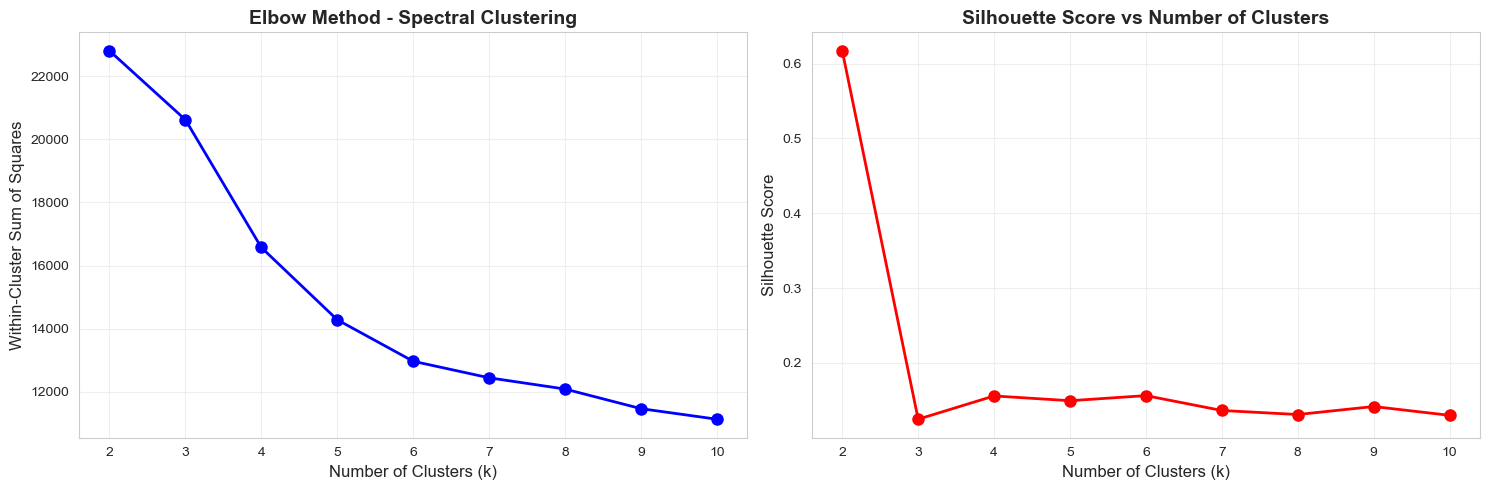

✓ Elbow method analysis complete


In [16]:
# Plot Elbow Method
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Within-Cluster Sum of Squares', fontsize=12)
axes[0].set_title('Elbow Method - Spectral Clustering', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Elbow method analysis complete")

In [17]:
print("\n[STEP 5] Applying Spectral Clustering with Best Parameters...")

# Use best parameters
best_n_clusters = int(best_result['n_clusters'])
best_affinity = best_result['affinity']

if best_affinity == 'nearest_neighbors':
    best_n_neighbors = int(best_result['n_neighbors'])
    spectral = SpectralClustering(
        n_clusters=best_n_clusters,
        affinity='nearest_neighbors',
        n_neighbors=best_n_neighbors,
        random_state=42,
        n_init=10
    )
    print(f"Configuration: n_clusters={best_n_clusters}, affinity='nearest_neighbors', n_neighbors={best_n_neighbors}")
else:
    best_gamma = best_result['gamma']
    spectral = SpectralClustering(
        n_clusters=best_n_clusters,
        affinity='rbf',
        gamma=best_gamma,
        random_state=42,
        n_init=10
    )
    print(f"Configuration: n_clusters={best_n_clusters}, affinity='rbf', gamma={best_gamma}")

spectral_labels = spectral.fit_predict(X_pca)

print(f"\n✓ Clustering complete with {best_n_clusters} clusters")
print(f"\nCluster distribution:")
for i in range(best_n_clusters):
    count = np.sum(spectral_labels == i)
    print(f"  Cluster {i}: {count} samples ({count/len(spectral_labels)*100:.2f}%)")


[STEP 5] Applying Spectral Clustering with Best Parameters...
Configuration: n_clusters=2, affinity='nearest_neighbors', n_neighbors=10

✓ Clustering complete with 2 clusters

Cluster distribution:
  Cluster 0: 2195 samples (99.05%)
  Cluster 1: 21 samples (0.95%)



[STEP 6] Visualizing Clustering Results...


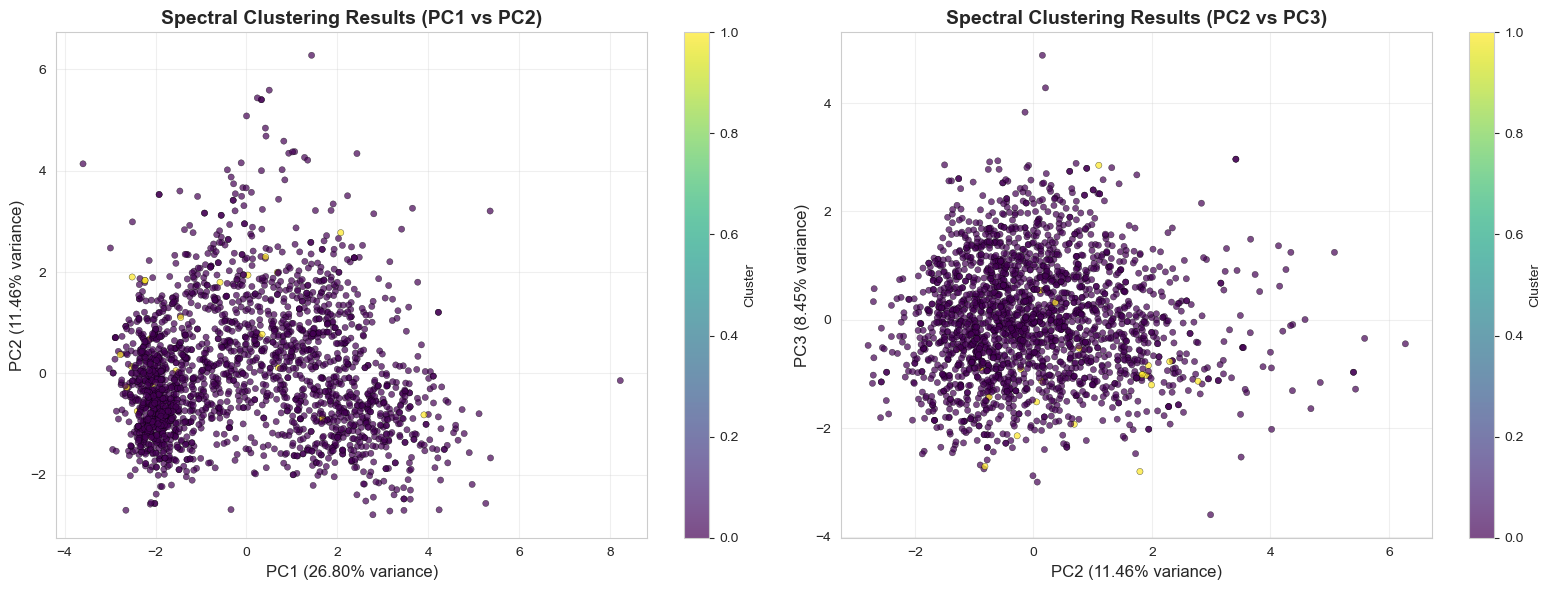

✓ 2D visualizations complete


In [18]:
print("\n[STEP 6] Visualizing Clustering Results...")

# 2D Visualization on first two principal components
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot with cluster colors
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=spectral_labels, cmap='viridis', 
                          s=20, alpha=0.7, edgecolors='k', linewidth=0.3)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=12)
axes[0].set_title('Spectral Clustering Results (PC1 vs PC2)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Plot 2: PC2 vs PC3
scatter2 = axes[1].scatter(X_pca[:, 1], X_pca[:, 2], 
                           c=spectral_labels, cmap='viridis', 
                           s=20, alpha=0.7, edgecolors='k', linewidth=0.3)
axes[1].set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=12)
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}% variance)', fontsize=12)
axes[1].set_title('Spectral Clustering Results (PC2 vs PC3)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print("✓ 2D visualizations complete")

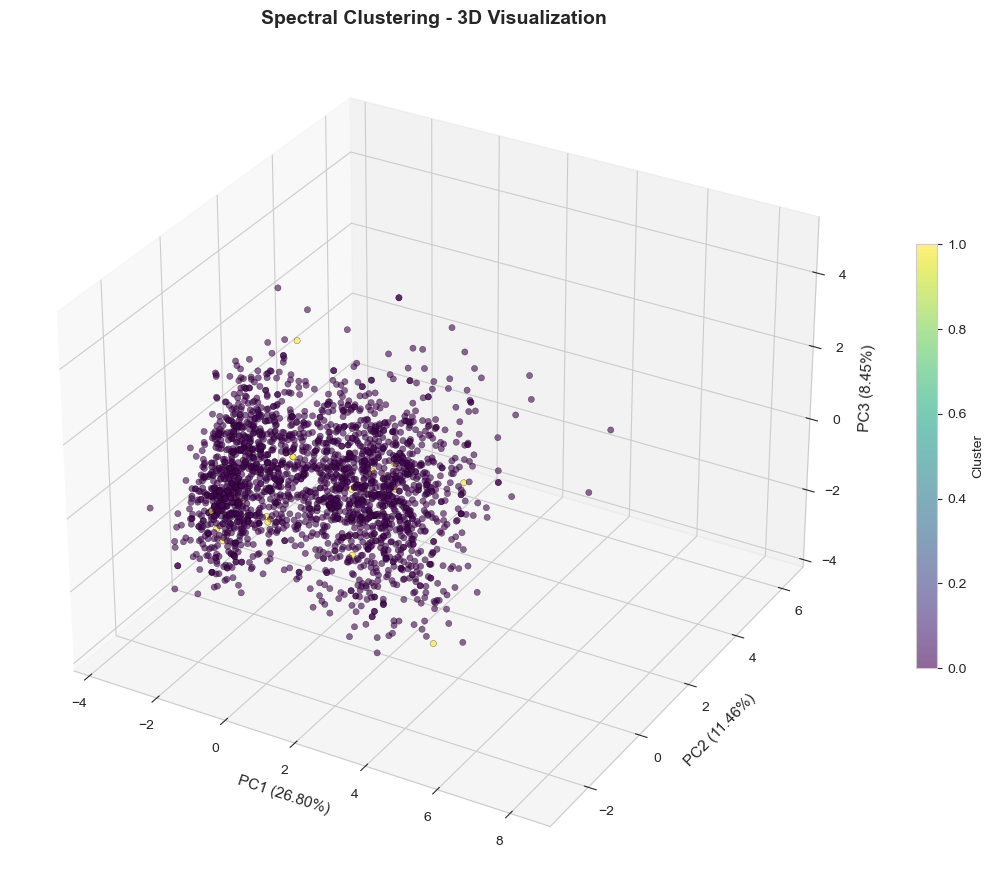

✓ 3D visualization complete


In [19]:
# 3D Visualization
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=spectral_labels, cmap='viridis',
                     s=20, alpha=0.6, edgecolors='k', linewidth=0.3)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)', fontsize=11)
ax.set_title('Spectral Clustering - 3D Visualization', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster', shrink=0.5)

plt.tight_layout()
plt.show()

print("✓ 3D visualization complete")

In [20]:
print("\n[STEP 7] Comprehensive Cluster Validation...")
print("="*80)

# 1. Silhouette Score
sil_score = silhouette_score(X_pca, spectral_labels)
print(f"\n1. Silhouette Score: {sil_score:.4f}")
print(f"   Range: [-1, 1], Higher is better")
print(f"   Interpretation: {sil_score:.4f} indicates ", end="")
if sil_score > 0.5:
    print("strong cluster structure")
elif sil_score > 0.25:
    print("reasonable cluster structure")
else:
    print("weak cluster structure")

# 2. Davies-Bouldin Index
db_score = davies_bouldin_score(X_pca, spectral_labels)
print(f"\n2. Davies-Bouldin Index: {db_score:.4f}")
print(f"   Range: [0, ∞), Lower is better")
print(f"   Interpretation: {db_score:.4f} indicates ", end="")
if db_score < 1.0:
    print("well-separated clusters")
else:
    print("overlapping clusters")

# 3. Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X_pca, spectral_labels)
print(f"\n3. Calinski-Harabasz Index: {ch_score:.2f}")
print(f"   Range: [0, ∞), Higher is better")
print(f"   Interpretation: Higher values indicate better-defined clusters")


[STEP 7] Comprehensive Cluster Validation...

1. Silhouette Score: 0.6173
   Range: [-1, 1], Higher is better
   Interpretation: 0.6173 indicates strong cluster structure

2. Davies-Bouldin Index: 0.6052
   Range: [0, ∞), Lower is better
   Interpretation: 0.6052 indicates well-separated clusters

3. Calinski-Harabasz Index: 216.56
   Range: [0, ∞), Higher is better
   Interpretation: Higher values indicate better-defined clusters


In [21]:
# 4. Gap Statistic
print(f"\n4. Computing Gap Statistic...")

def compute_gap_statistic(X, labels, n_refs=10):
    """
    Compute the Gap Statistic for clustering validation
    """
    # Compute within-cluster dispersion for actual clustering
    unique_labels = np.unique(labels)
    wk = 0
    for label in unique_labels:
        cluster_points = X[labels == label]
        center = cluster_points.mean(axis=0)
        wk += np.sum((cluster_points - center) ** 2)
    
    # Generate reference datasets and compute their dispersion
    ref_dispersions = []
    for i in range(n_refs):
        # Generate random reference data
        random_data = np.random.uniform(X.min(axis=0), X.max(axis=0), size=X.shape)
        
        # Cluster reference data
        if best_affinity == 'nearest_neighbors':
            sc_ref = SpectralClustering(
                n_clusters=len(unique_labels),
                affinity='nearest_neighbors',
                n_neighbors=best_n_neighbors,
                random_state=42+i,
                n_init=10
            )
        else:
            sc_ref = SpectralClustering(
                n_clusters=len(unique_labels),
                affinity='rbf',
                gamma=best_gamma,
                random_state=42+i,
                n_init=10
            )
        ref_labels = sc_ref.fit_predict(random_data)
        
        # Compute dispersion for reference
        ref_wk = 0
        for label in np.unique(ref_labels):
            cluster_points = random_data[ref_labels == label]
            center = cluster_points.mean(axis=0)
            ref_wk += np.sum((cluster_points - center) ** 2)
        ref_dispersions.append(np.log(ref_wk))
        
        print(f"   Computing reference {i+1}/{n_refs}...", end='\r')
    
    # Compute gap statistic
    gap = np.mean(ref_dispersions) - np.log(wk)
    return gap

gap_stat = compute_gap_statistic(X_pca, spectral_labels, n_refs=10)
print(f"\n   Gap Statistic: {gap_stat:.4f}")
print(f"   Interpretation: Positive gap indicates good clustering structure")


4. Computing Gap Statistic...
   Computing reference 10/10...
   Gap Statistic: 1.5367
   Interpretation: Positive gap indicates good clustering structure


In [22]:
# 5. Silhouette Analysis per Cluster
print(f"\n5. Silhouette Analysis per Cluster:")

silhouette_vals = silhouette_samples(X_pca, spectral_labels)
for i in range(best_n_clusters):
    cluster_silhouette_vals = silhouette_vals[spectral_labels == i]
    print(f"   Cluster {i}: Mean = {cluster_silhouette_vals.mean():.4f}, "
          f"Min = {cluster_silhouette_vals.min():.4f}, "
          f"Max = {cluster_silhouette_vals.max():.4f}, "
          f"Size = {len(cluster_silhouette_vals)}")


5. Silhouette Analysis per Cluster:
   Cluster 0: Mean = 0.6174, Min = 0.2924, Max = 0.7010, Size = 2195
   Cluster 1: Mean = 0.5995, Min = 0.4213, Max = 0.6606, Size = 21


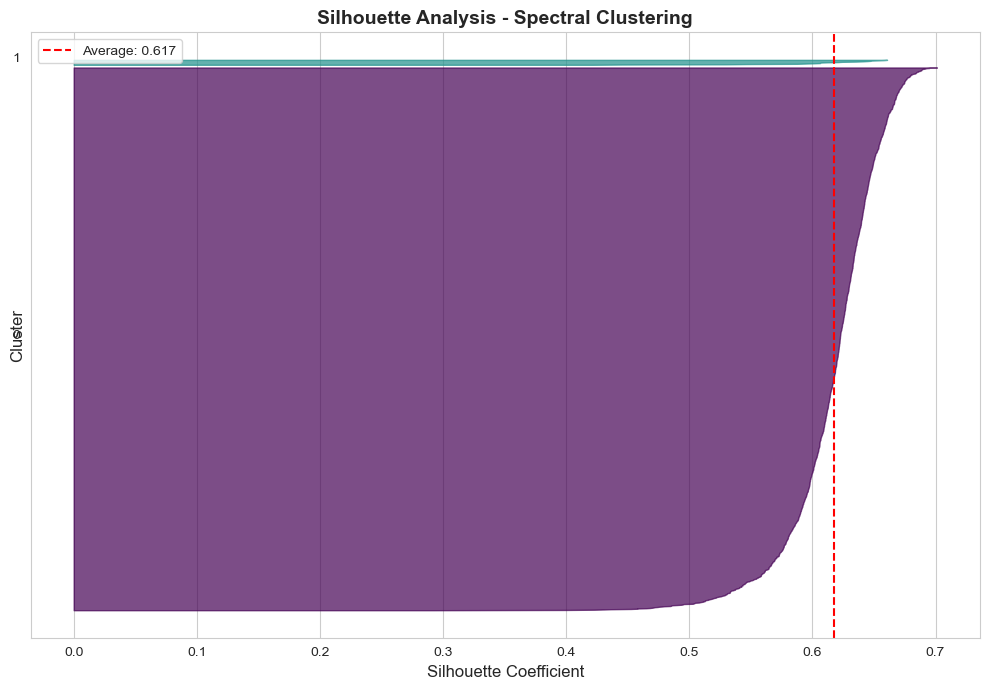

✓ Silhouette analysis visualization complete


In [23]:
# Visualize silhouette analysis
fig, ax = plt.subplots(figsize=(10, 7))
y_lower = 10

for i in range(best_n_clusters):
    cluster_silhouette_vals = silhouette_vals[spectral_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(float(i) / best_n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette Coefficient", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)
ax.set_title("Silhouette Analysis - Spectral Clustering", fontsize=14, fontweight='bold')
ax.axvline(x=sil_score, color="red", linestyle="--", label=f'Average: {sil_score:.3f}')
ax.set_yticks([])
ax.legend()
plt.tight_layout()
plt.show()

print("✓ Silhouette analysis visualization complete")

In [24]:
print("\n[STEP 8] Cluster Characterization...")
print("="*80)

# Add cluster labels to original dataframe
customer_df_encoded['Cluster'] = spectral_labels

# Analyze cluster characteristics
print("\nCluster Statistics (Original Feature Space):")
print("-" * 80)

for cluster_id in range(best_n_clusters):
    print(f"\n{'CLUSTER ' + str(cluster_id):=^80}")
    cluster_data = customer_df_encoded[customer_df_encoded['Cluster'] == cluster_id]
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(customer_df_encoded)*100:.2f}%)")
    print(f"\nKey Characteristics:")
    
    # Select most distinguishing features
    feature_means = cluster_data.drop('Cluster', axis=1).mean()
    print(feature_means.to_string())


[STEP 8] Cluster Characterization...

Cluster Statistics (Original Feature Space):
--------------------------------------------------------------------------------

===================================CLUSTER 0====================================
Size: 2195 customers (99.05%)

Key Characteristics:
Income                 52314.269248
Recency                   48.974032
NumDealsPurchases          2.323462
NumWebPurchases            4.089749
NumCatalogPurchases        2.676993
NumStorePurchases          5.806378
Complain                   0.000000
Age                       56.143964
Customer_days           4509.862415
education_encoded          1.975399
alone_encoded              0.354442
num_child                  0.944875
spend                    609.282005
num_cmp_accepted           0.450114

===================================CLUSTER 1====================================
Size: 21 customers (0.95%)

Key Characteristics:
Income                 45242.285714
Recency                   53.0

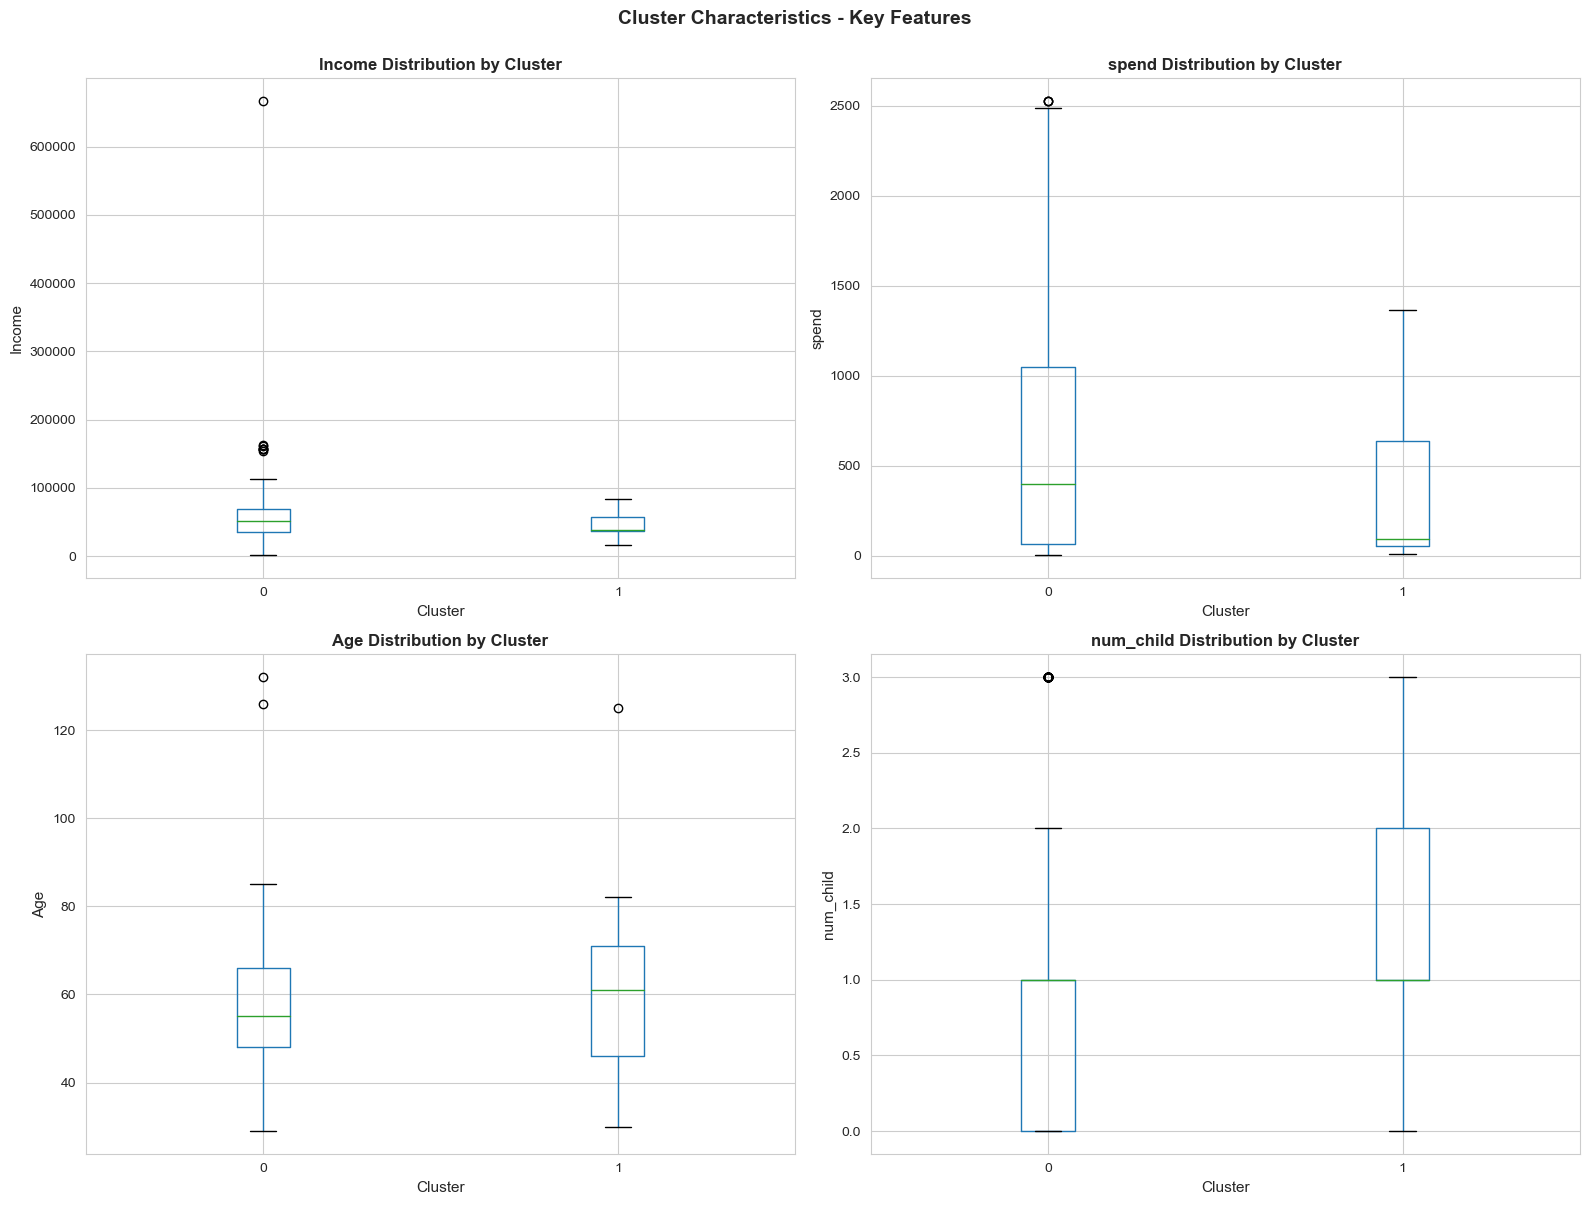


✓ Cluster characteristics visualization complete


In [25]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

key_features = ['Income', 'spend', 'Age', 'num_child']

for idx, feature in enumerate(key_features):
    if feature in customer_df_encoded.columns:
        customer_df_encoded.boxplot(column=feature, by='Cluster', ax=axes[idx])
        axes[idx].set_title(f'{feature} Distribution by Cluster', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Cluster', fontsize=11)
        axes[idx].set_ylabel(feature, fontsize=11)
        plt.sca(axes[idx])
        plt.xticks(rotation=0)

plt.suptitle('Cluster Characteristics - Key Features', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✓ Cluster characteristics visualization complete")


[STEP 9] Creating Comparison Heatmap...


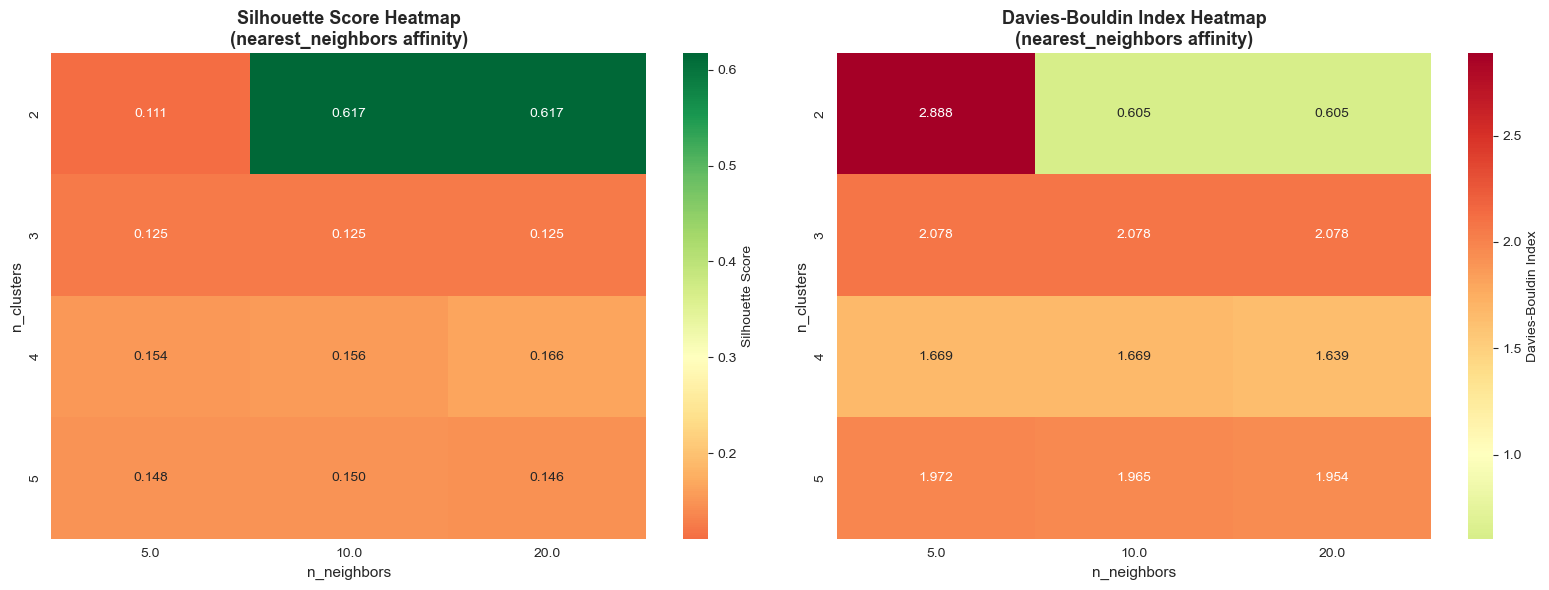

✓ Hyperparameter comparison heatmap complete


In [26]:
print("\n[STEP 9] Creating Comparison Heatmap...")

# Create heatmap for hyperparameter comparison
pivot_sil = results_df[results_df['affinity'] == 'nearest_neighbors'].pivot_table(
    values='silhouette',
    index='n_clusters',
    columns='n_neighbors'
)

pivot_db = results_df[results_df['affinity'] == 'nearest_neighbors'].pivot_table(
    values='davies_bouldin',
    index='n_clusters',
    columns='n_neighbors'
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(pivot_sil, annot=True, fmt='.3f', cmap='RdYlGn', center=0.3, ax=axes[0],
            cbar_kws={'label': 'Silhouette Score'})
axes[0].set_title('Silhouette Score Heatmap\n(nearest_neighbors affinity)', 
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('n_neighbors', fontsize=11)
axes[0].set_ylabel('n_clusters', fontsize=11)

sns.heatmap(pivot_db, annot=True, fmt='.3f', cmap='RdYlGn_r', center=1.0, ax=axes[1],
            cbar_kws={'label': 'Davies-Bouldin Index'})
axes[1].set_title('Davies-Bouldin Index Heatmap\n(nearest_neighbors affinity)', 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('n_neighbors', fontsize=11)
axes[1].set_ylabel('n_clusters', fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Hyperparameter comparison heatmap complete")